<a href="https://colab.research.google.com/github/aniilkeles/DeepLearningNotes/blob/main/Convolutional%20Neural%20Network/Pytorch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_data_loaders(batch_size=64):
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) # RGB KANALLARINI NORMALİZE İŞLEMİ
  ])

  #CIFAR10 DATASET DOWNLOAD
  train_set = torchvision.datasets.CIFAR10(root = '/.data',train=True,download=True,transform=transform)
  test_set = torchvision.datasets.CIFAR10(root = '/.data',train=False,download=True,transform=transform)

  #Pytorch data loader
  train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=False)

  return train_loader,test_loader

In [3]:
# visualize dataset
# verileri normalize etmiştik transform işlemi uygulamıştık siyah beyaz olmadığı için bozulacaktır bu yüzden ters normalizasyon uygulayıp görselleştireceğim.
def imshow(img):
    img = img/2 + 0.5 # normalize işleminin tersi
    np_img = img.numpy() # tensorden numpy'a
    plt.imshow(np.transpose(np_img, (1,2,0))) # 3 kanal için RGB için doğru sıralama gösterme işlemi (1,2,0)
    plt.show()

# veri kümesinden örnek görseller
def get_sample_images(train_loader):
  data_iter = iter(train_loader)
  images,labels = next(data_iter)
  return images,labels

def visualize(n):
  train_loader,test_loader = get_data_loaders()
  # n tane veri görselleştirme işlemi
  images,labels = get_sample_images(train_loader)
  plt.figure()
  for i in range(n):
    plt.subplot(1,n,i+1)
    imshow(images[i])
    plt.title(f"Label : {labels[i].item()}")
    plt.axis("off")
  plt.show()

100%|██████████| 170M/170M [00:03<00:00, 43.1MB/s]


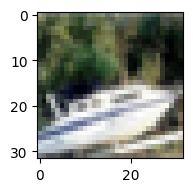

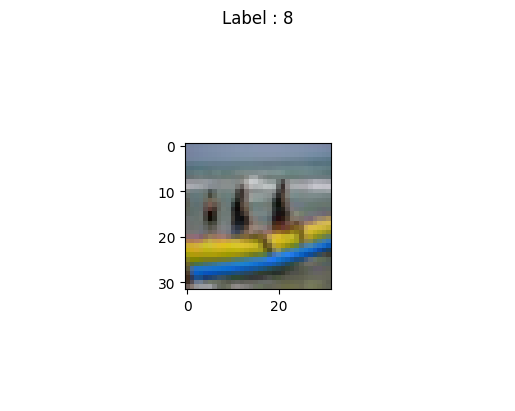

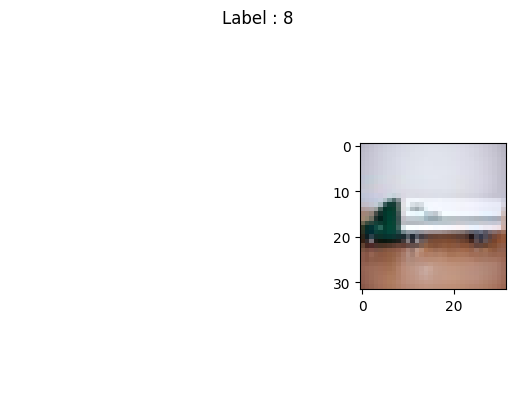

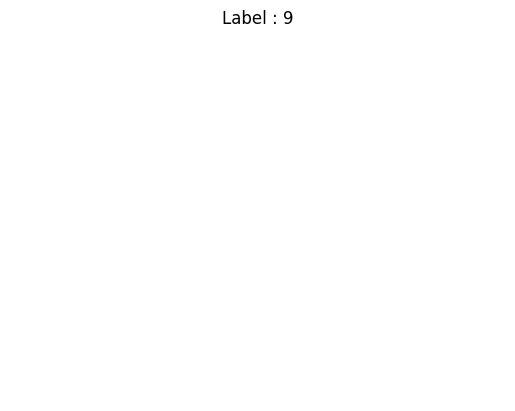

In [4]:
visualize(3)

In [5]:
# model oluşumu
# inheritance from neural network
class CNN(nn.Module) :
  def __init__(self):
    super(CNN,self,).__init__() # inheritance işlemi
    self.conv1 = nn.Conv2d(3,32,kernel_size=3,padding=1) # convolutional 2 boyutlu bir layer tanımlamamız gerekiyor ilk önce, in_channels=> inputlarımızın yani görüntülerimizin kanal sayısı , burda rgb = 3
    self.relu = nn.ReLU()         # out_channels => filtre sayısı , layerın çıktıları filtre olarak adlandırabiliriz 32 olarak tanımlanır.. kernel_size => convolotional layerda bulunan filtrelerimizin boyutu 3*3 matrisler şekilde tanımlanır
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2)         # padding dolgu demektir padding giriş görüntüsünün kenarlarını sıfırlar veya başka değerler ekleyerek konvolüsyon işlemi sırasında çıktı boyutunu korumaya veya belirli bir şekilde korumaya yarayan bir parametredir.
    self.conv2 = nn.Conv2d(32,64,kernel_size=3,padding=1)          # padding=1 yaptık yani giriş görüntüsünün her bir kenarına 1 piksellik 0 ekledik
    self.dropout = nn.Dropout(0.2)          # genelde relu kullanılır çünkü türevlenilirliği kolay , tanh aktivasyon fonksiyonu var ama türevlenebilirliği zor
              # 2x2 boyutunda pooling katmanı oluşturdum.Stride = 2 dediğimiz zaman convolutional filtrelerimiz görüntü üzerinde 2 piksel 2 piksel sağa kayar.
              # layerları birbirine bağlayabilmek çok önemli bu yüzden convolutional layerlar arasındaki girdiler ve çıktılar uyumlu olmak zorunda
              # 2. convolutional layerımızda çıkan output 32 olduğu için input 32 olmak zorunda 64 burda bir hiperparametre kendimiz karar veriririz
              # dropout neural networkde bulunan hücrelerin yüzde 20 sinin çalışıp çalışmamasını belirler.Oranı azaltmak overfitting'e olanak tanıyacaktır.
              # buraya kadar olan işlemler feature extraction işlemleriydi.
    self.fc1=nn.Linear(64*8*8,128) # => (64*8*8) dememizin sebebi image 3x32x32 => conv(32) => relu(32) => pool(16) 16 ya düşmesinin sebebi stride yaptığımız için , 128 nöron sayısı output , input 64*8*8 = 4096
                               # conv(16) => relu(16) => pool(8) => image = 8x8
    self.fc2 = nn.Linear(128,10) # burası output layer kaç tane etiket varsa outpu o olacak cifar 10 tane etiket olduğu için 10


  # forward fonksiyonumuzdada biz image 3x32x32 -> conv(32) => relu(32) => pool(16)
  # # conv(16) => relu(16) => pool(8) => image = 8x8
  # flatten
  # fc1 -> relu -> droput
  # fc2 -> output
  def forward(self,x):
    x = self.pool(self.relu(self.conv1(x))) # ilk convolution blok
    x = self.pool(self.relu(self.conv2(x))) # ikinci convolution blok
    x = x.view(-1,64*8*8) # -1 demek boyutunu kendin belirle demek , burda flatten layer tanımlamadık , flatten katmanı aslında
    x = self.dropout(self.relu(self.fc1(x))) # fully connected layer
    x = self.fc2(x) # output

    return x

In [6]:
model = CNN()

In [7]:
# define loss function and optimizer
define_loss_and_optimizer = lambda model: (
    nn.CrossEntropyLoss(),
    optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
)
# momentum SGD optimizasyon algoritma ' ya hız kazandıran bir parametredir.
# sgd => stochastic gradient descent

In [8]:
# training
def train_model(model,train_loader,criterion,optimizer,epochs=5):
   # model eğitim aşaması
   model.train()
   # loss değerlerini saklamak için liste
   train_losses = []
   # for döngüsü oluşturup belirtilen epoch sayısı kadar eğitim
   for epoch in range(epochs):
      # total_loss değişkeniyle toplam kayıp değerini saklamak için tanımlayacağız.
      total_loss = 0
      # tüm eğitim veri setini taramak için bir for döngüsü kullanacağım.
      for images,labels in train_loader:
          # gradyanları sıfırlama işlemi yapacağız
          optimizer.zero_grad()
          # forward propagation prediction yapacağım.
          outputs = model(images) # burdaki outputlar labellar oluyor yani değerler
          # loss değeri hesaplayacağım.
          loss = criterion(outputs,labels)
          # geri yayılım (gradyan hesaplama)
          loss.backward()
          # öğrenme işlemi yani ağırlık güncelleme işlemi yapacağım.
          optimizer.step()

          total_loss += loss.item()

      avg_loss =  total_loss/len(train_loader) # ortalama kayıp hesaplama
      train_losses.append(avg_loss)
      print(f"Epoch : {epoch+1 }/{epochs}, Loss : {avg_loss:.5f}")

  # loss grafiği
   plt.figure()
   plt.plot(range(1,epochs+1),train_losses,marker="o",linestyle="-",label = "Train Loss")
   plt.xlabel("Epochs")
   plt.ylabel("Loss")
   plt.title("Training Loss")
   plt.legend()
   plt.show()

Epoch : 1/10, Loss : 2.08055
Epoch : 2/10, Loss : 1.71912
Epoch : 3/10, Loss : 1.52103
Epoch : 4/10, Loss : 1.40229
Epoch : 5/10, Loss : 1.32894
Epoch : 6/10, Loss : 1.26395
Epoch : 7/10, Loss : 1.20919
Epoch : 8/10, Loss : 1.15987
Epoch : 9/10, Loss : 1.11603
Epoch : 10/10, Loss : 1.07510


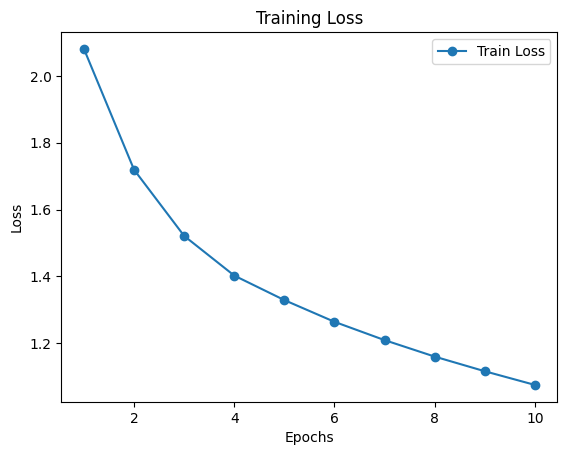

In [9]:
train_loader,test_loader=get_data_loaders()
model = CNN()
criterion,optimizer = define_loss_and_optimizer(model)
train_model(model,train_loader,criterion,optimizer,epochs=10)

In [14]:
def test_model(model,test_loader,dataset_type):
  model.eval() # değerlendirme modu
  correct = 0 # doğru tahmin sayacı
  total = 0 # toplam veri sayacı

  with torch.no_grad(): # gradyan hesaplamasını kapatıyorum.
       for images,labels in test_loader:
            outputs = model(images) # prediction
            _, predicted = torch.max(outputs,1) # en yüksek olasılıklı sınıfı seçmiş oluyorum.
            total += labels.size(0) # toplam veri sayısını günceller
            correct += (predicted==labels).sum().item() # doğru tahminleri sayar.

  print(f"{dataset_type} accuracy : {100*correct / total} %")

In [17]:
test_model(model,test_loader,dataset_type="test") # test accuracy : 62.83 %
test_model(model,train_loader,dataset_type="training") # training accuracy : 65.248 %

test accuracy : 62.83 %
training accuracy : 65.248 %


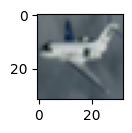

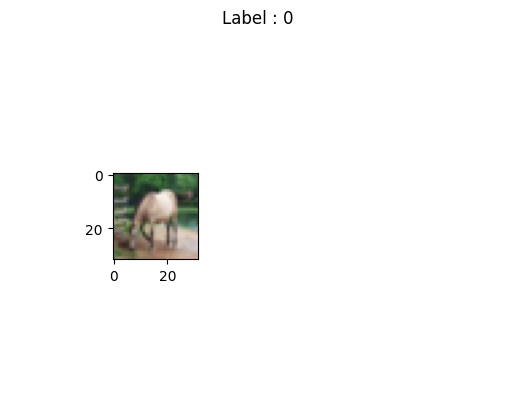

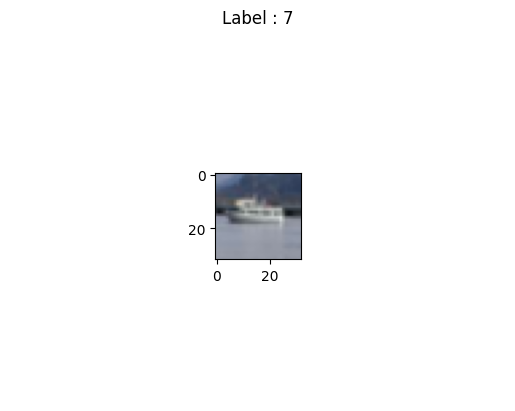

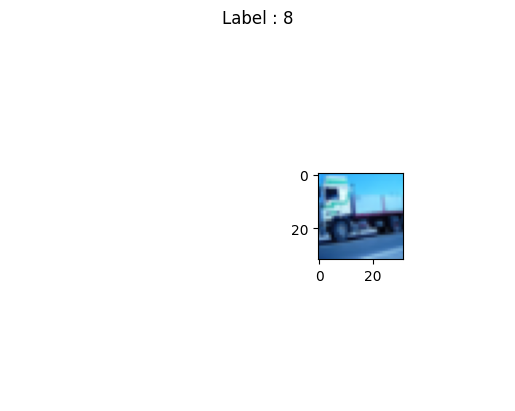

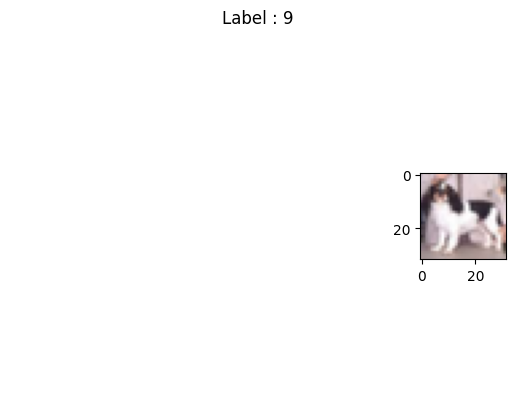

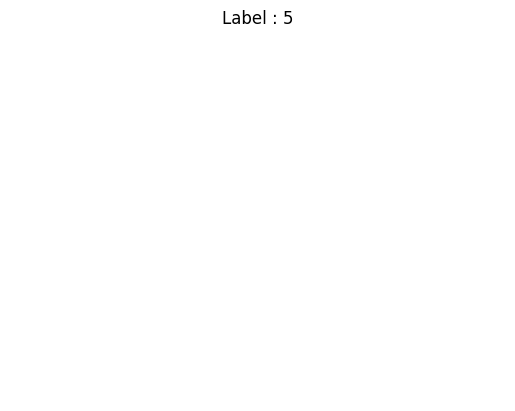

Epoch : 1/1, Loss : 2.04903


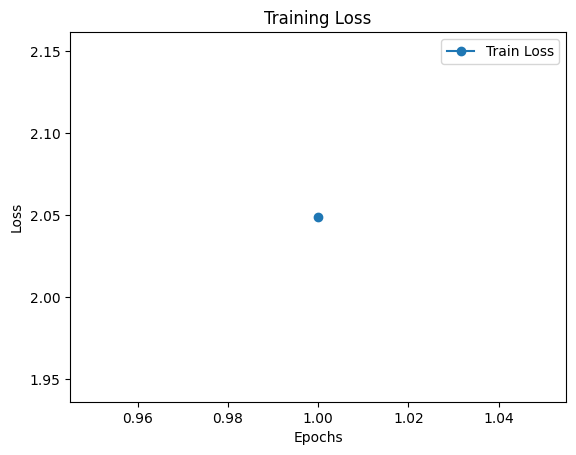

test accuracy : 37.38 %
training accuracy : 37.206 %


In [18]:
if __name__ == "__main__":
   train_loader,test_loader = get_data_loaders()
   visualize(5)

   model = CNN()
   criterion,optimizer = define_loss_and_optimizer(model)
   train_model(model,train_loader,criterion,optimizer,epochs=1)

   test_model(model,test_loader,dataset_type="test") # test accuracy : 62.83 %
   test_model(model,train_loader,dataset_type="training") # training accuracy : 65.248 %